# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [34]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
        
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# import mmseg
!nvidia-smi

Thu Feb  1 15:24:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 24%   43C    P8     8W / 150W |   2171MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 42%   71C    P2    60W / 150W |   4948MiB / 11178MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

# 0. Initialize and Load Pre-trained Models

In [35]:
# model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file
# model_checkpoint_path = "/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/checkpoint0011_4scale.pth" #
# "ckpts/checkpoint0023_4scale.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

# model_config_path = "config/DINO/DINO_4scale_swinLARGE.py"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection_old/checkpoints/checkpoint0029_4scale_swin.pth"

model_config_path = "config/DINO/DINO_4scale_swinBASE.py"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_chestxdetdataset_detect_/run04/checkpoint.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_chestxdetdataset_detect_/run07/checkpoint_best_regular.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection_old2/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganDetect_/runSOL_03/checkpoint.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/run201_LL_LocEncDec3Hs/ckpt_E3_TH2.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/run104_HLL/ckpt_E4_TH3.pth"

model_checkpoint_path = "/mnt/dfs/nuislam/Projects/IntegratedModel_GitHubV/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_Node21_Nodule/run103_DFS_LocCls/ckpt_E141_TH1.pth"  # ckpt_E1_TH0 # ckpt_E3_TH2

In [36]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
args.backbonemodel = "Swin-B"
args.taskcomponent = "detection"
# args.dataset_file = "coco"
# args.dataset_file = "chestxdetdataset"
# args.dataset_file = "vindrcxr_detect"
args.dataset_file = "vindrcxr_OrganDetect"
# args.init = None
args.init = "ark"
# args.backbone_dir = "/mnt/dfs/nuislam/Projects/DINO_Detection_old/checkpoints/checkpoint0029_4scale_swin.pth"
args.backbone_dir = "/mnt/dfs/nuislam/pretrainedModels/Ark6/TSconsist_NoOD_MIMIC_CheXpert_ChestXray14_RSNAPneumonia_VinDrCXR_Shenzhen_ep200.pth.tar"
# args.backbone_dir = None
args.num_classes = 2 # was 91 COCO
args.numClasses = 1
args.dn_labelbook_size = 3

args.lr_backbone = 0.001
model, criterion, postprocessors = build_model_main(args)

checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
# checkpoint = torch.load(args.backbone_dir , map_location='cpu')
# for k,v in checkpoint['model'].items():
#     print(k, v.shape)

# State_CHECK=model.load_state_dict(checkpoint['model'], strict=False)

from models.load_weights_model import load_weights
model = load_weights(model, args)
State_CHECK = model.load_state_dict(checkpoint['model'], strict=True)
print(State_CHECK)
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
[Model Info.] Backbone Pre-trained Weights Loaded: /mnt/dfs/nuislam/pretrainedModels/Ark6/TSconsist_NoOD_MIMIC_CheXpert_ChestXray14_RSNAPneumonia_VinDrCXR_Shenzhen_ep200.pth.tar
[Model Info.] Model Weight Load PREFIX:  backbone.0.

[Model Info.] Pretrained weights loaded for backbone: /mnt/dfs/nuislam/pretrainedModels/Ark6/TSconsist_NoOD_MIMIC_CheXpert_ChestXray14_RSNAPneumonia_VinDrCXR_Shenzhen_ep200.pth.tar
[Model CHECK] Loaded backbone weights -- Before & After --  norm.weight and norm.bias. tensor(512., grad_fn=<AddBackward0>) tensor(378.2670, grad_fn=<AddBackward0>)
[Model CHECK] Loaded backbone weights -- Before & After --  norm.weight and norm.bias. tensor(1024., grad_fn=<AddBackward0>) tensor(2035.9669, grad_fn=<AddBackward0>)
<All keys matched successfully>


In [5]:
model, criterion, postprocessors = build_model_main(args)
# print( model )

# ww = model.state_dict()
# for k,v in ww.items():
#     print(k, v.shape)

for name, param in model.named_parameters():
    param.requires_grad = True

# for name, param in model.named_parameters():
#     if ('backbone' in name) and ('segmentation_' not in name): # BACKBONE only
#         param.requires_grad = False
# for name, param in model.named_parameters():
#     if ('transformer.encoder' in name): ## Only Localization Encoder
#         param.requires_grad = False
# for name, param in model.named_parameters(): ## Newly added by NAD
#     if ('transformer.enc_output' in name) or ('transformer.enc_output_norm' in name) or ('transformer.enc_outputMem_LinearProjection' in name): ## Localizer Encoder -> Query Selection Box Selection parts
#         param.requires_grad = True
        
# for name, param in model.named_parameters():
#     if ('backbone' in name) and ('segmentation_' not in name): # BACKBONE only
#         param.requires_grad = True
# for name, param in model.named_parameters():
#     if ('segmentation_' in name): # Segmentation only
#         param.requires_grad = True
# for name, param in model.named_parameters():
#     if ('segmentation_head' in name): # Segmentation only
#         param.requires_grad = True
# for name, param in model.named_parameters():
#     if ('Locnorm' in name) or ('Segnorm' in name):
#         param.requires_grad = True
# for name, param in model.named_parameters():
#     if ('decoder' in name): ## Only Decoder
#         param.requires_grad = True
# for name, param in model.named_parameters():
#     if ('transformer.encoder' in name): ## Only Encoder
#         param.requires_grad = True

# print("params:\n"+json.dumps({n: p.numel() for n, p in model.named_parameters() if p.requires_grad}, indent=2))

print()
print("-------------------------")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

print("params:\n"+json.dumps({n: p.numel() for n, p in model.named_parameters() if p.requires_grad}, indent=2))

## Only Backbone (Swin-B): 86,751,673
## Only Segmentation: 20,897,923
## Only Localizer Encoder: 7,693,056
## Only Localizer Decoder: 9,606,408
## Total Trainable Parameters: 147148620  [one backbone, one encoder, three decoders]

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
[Model Info.] Backbone Pre-trained Weights Loaded: /mnt/dfs/nuislam/pretrainedModels/Ark6/TSconsist_NoOD_MIMIC_CheXpert_ChestXray14_RSNAPneumonia_VinDrCXR_Shenzhen_ep200.pth.tar

-------------------------
Total Trainable Parameters: 396288
params:
{
  "transformer.enc_output.0.weight": 65536,
  "transformer.enc_output.0.bias": 256,
  "transformer.enc_output.1.weight": 65536,
  "transformer.enc_output.1.bias": 256,
  "transformer.enc_output.2.weight": 65536,
  "transformer.enc_output.2.bias": 256,
  "transformer.enc_output_norm.0.weight": 256,
  "transformer.enc_output_norm.0.bias": 256,
  "transformer.enc_output_norm.1.weight": 256,
  "transformer.enc_output_norm.1.bias": 256,
  "transformer.enc_output_norm.2.weight": 256,
  "transformer.enc_output_norm.2.bias": 256,
  "transformer.enc_outputMem_LinearProjection.0.weight": 65536,
  "transformer.enc_outputMem_LinearProjection.0.bias": 256,
  "transformer.enc_outputMem_LinearProjection.1.weight": 65

In [5]:
import torch.nn as nn

temp_i=0
for name, param in model.named_parameters():
#     if '.weight' in name and param.sum().item() == 0:
#         temp_i=temp_i+1
#         print(temp_i, name, param.sum().item() )
        
    if '.weight' in name and torch.sum(param.data) == 0:
        temp_i=temp_i+1
        nn.init.xavier_uniform_(param.data)
        print(temp_i, name, param.sum().item() )
#     if param.sum().item() == 0:
#         nn.init.xavier_uniform_(model.name.weight)
        
    
#     elif 'bias' in name:
#         print(name, param.sum().item() )

1 transformer.encoder.layers.0.self_attn.sampling_offsets.weight -1.3890788555145264
2 transformer.encoder.layers.0.self_attn.attention_weights.weight -9.84431266784668
3 transformer.encoder.layers.1.self_attn.sampling_offsets.weight -14.654779434204102
4 transformer.encoder.layers.1.self_attn.attention_weights.weight 4.78697395324707
5 transformer.encoder.layers.2.self_attn.sampling_offsets.weight -0.4999408721923828
6 transformer.encoder.layers.2.self_attn.attention_weights.weight 1.7118803262710571
7 transformer.encoder.layers.3.self_attn.sampling_offsets.weight 23.21902847290039
8 transformer.encoder.layers.3.self_attn.attention_weights.weight -2.2198026180267334
9 transformer.encoder.layers.4.self_attn.sampling_offsets.weight 33.83313751220703
10 transformer.encoder.layers.4.self_attn.attention_weights.weight -18.25981330871582
11 transformer.encoder.layers.5.self_attn.sampling_offsets.weight -0.2598452568054199
12 transformer.encoder.layers.5.self_attn.attention_weights.weight 10

In [21]:
model.parameters()

<generator object Module.parameters at 0x7fad7c29b350>

In [37]:
# load coco names
# with open('util/coco_id2name.json') as f: 
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}
    
# with open('util/chestxdet_id2name.json') as f: # chestxdet_id2name
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}
    
# with open('util/vindrcxr_id2name.json') as f: # vindrcxr_id2name
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}


# with open('util/vindrcxrOrgan_id2name.json') as f: # vindrcxr_id2name
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}
    
# with open('util/vindrcxrOrganHeart_id2name.json') as f: # vindrcxr_id2name
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}
    
# with open('util/vindrcxrOrganLeftLung_id2name.json') as f: # vindrcxr_id2name
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}
    
# with open('util/vindrcxrOrganLung_id2name.json') as f: # vindrcxr_id2name 
#     id2name = json.load(f)
#     id2name = {int(k):v for k,v in id2name.items()}
    
with open('util/node21Nodule_id2name.json') as f: # node21Nodule_id2name
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [38]:
# args.dataset_file = 'coco'
# args.coco_path = "/mnt/dfs/nuislam/Data/coco-2017/" # the path of coco
# args.fix_size = False
# dataset_val = build_dataset(image_set='val', args=args)   


# args.dataset_file = 'chestxdetdataset'
# args.coco_path = "/mnt/dfs/nuislam/Data/ChestX-Det/" # the path of coco
# args.fix_size = False
# ## dataset_val = build_dataset(image_set='chestxdet_test', args=args)  
# dataset_val = build_dataset(image_set='chestxdet_test', args=args)
# print("Validation Set:", len(dataset_val) )
# dataset_train = build_dataset(image_set='chestxdet_train', args=args)
# print("Training Set:", len(dataset_val) )

# args.dataset_file = 'vindrcxr_detect'
# args.coco_path = "/mnt/dfs/jpang12/datasets/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/" # the path of coco
# args.fix_size = False
# ## dataset_val = build_dataset(image_set='chestxdet_test', args=args)  
# dataset_val = build_dataset(image_set='vindrcxr_test', args=args)


# args.dataset_file = 'vindrcxr_OrganDetect'
# args.coco_path = "/mnt/dfs/jpang12/datasets/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/" # the path of coco
# args.fix_size = False
# # dataset_train = build_dataset(image_set='vindrcxrOrgan_train', args=args)
# dataset_val = build_dataset(image_set='vindrcxrOrgan_test', args=args)
# len(dataset_val)

# args.dataset_file = 'vindrcxr_OrganDetect'
# args.coco_path = "/mnt/dfs/jpang12/datasets/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/" # the path of coco
# args.fix_size = False
# # dataset_train = build_dataset(image_set='vindrcxrOrgan_trainHeart', args=args)
# dataset_val = build_dataset(image_set='vindrcxrOrgan_testHeart', args=args)
# len(dataset_val)

# args.dataset_file = 'vindrcxr_OrganDetect'
# args.coco_path = "/mnt/dfs/jpang12/datasets/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/" # the path of coco
# args.fix_size = False
# # dataset_train = build_dataset(image_set='vindrcxrOrgan_train', args=args)
# dataset_val = build_dataset(image_set='vindrcxrOrgan_testLung', args=args)
# len(dataset_val)

args.dataset_file = 'node21_noduleDataset'
args.coco_path = "/mnt/dfs/nuislam/Data/NODE21_ann/" # the path of coco
args.fix_size = False
# dataset_train = build_dataset(image_set='vindrcxrOrgan_train', args=args)
dataset_val = build_dataset(image_set='node21_noduleDataset_test', args=args) # node21_noduleDataset_train node21_noduleDataset_test
len(dataset_val)


[Dataset Annotation] FILE: (PosixPath('/mnt/dfs/nuislam/Data/NODE21_ann/images_png'), PosixPath('/mnt/dfs/nuislam/Data/NODE21_ann/Node21_Nodule_Bbox_Ann_test_2.json'))

data_aug_params: {
  "scales": [
    480
  ],
  "max_size": 480,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


1046

## 1.2 Get an Example and Visualize it

In [39]:
image, targets = dataset_val[3]
len(dataset_val)
# image, targets = dataset_test[1]

1046

torch.Size([3, 480, 480]) tensor(-2.1179) tensor(2.6400)
image_id: tensor([750])
size: tensor([480, 480])
boxes: tensor([[0.3584, 0.2617, 0.0508, 0.0410]])
['Nodule']


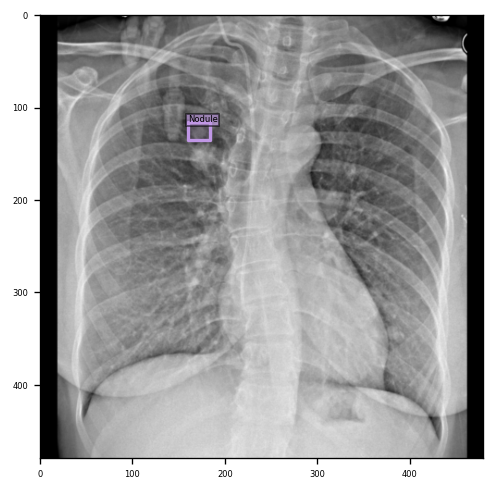

{'boxes': tensor([[0.3584, 0.2617, 0.0508, 0.0410]]), 'labels': tensor([1]), 'image_id': tensor([750]), 'area': tensor([479.8828]), 'iscrowd': tensor([0]), 'orig_size': tensor([1024, 1024]), 'size': tensor([480, 480])}



In [40]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(), 
])


image, targets = dataset_val[750]
# image, targets = dataset_train[10]

# image = np.array(image)
# image = np.transpose(image, (2, 0, 1))

# image = transform(image)
print(image.shape, image.min(), image.max())
print("image_id:",targets['image_id'])
print("size:",targets['size'])
print("boxes:",targets['boxes'])


# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
print(box_label)
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

print(targets)
print()
# print(gt_dict)
# print()
# print(gt_dict['boxes']*1024)

In [12]:
# H, W = gt_dict['size'].tolist() 
# print("ImageSize:", H,W)
# unnormbbox = gt_dict['boxes'][0] * torch.Tensor([W, H, W, H])
# # unnormbbox = unnormbbox
# print(unnormbbox)
# unnormbbox[:2] -= unnormbbox[2:] / 2
# print("x, y, width, height ",unnormbbox)

# print(800-unnormbbox)

empty_target_cnt = 0
for i in range(0, len(dataset_val)):
    _, targets = dataset_val[i]
    if len(targets['boxes']) == 0:
        empty_target_cnt = empty_target_cnt + 1
print("Empty Target BBOX:", empty_target_cnt)
print("Done...")

Empty Target BBOX: 64
Done...


## 1.3 Visualize Model Predictions

In [41]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    x_end_intersection = min(x1 + w1, x2 + w2)
    y_end_intersection = min(y1 + h1, y2 + h2)
    intersection_area = max(0, x_end_intersection - x_intersection) * max(0, y_end_intersection - y_intersection)
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

def calculate_miou(target_bboxes, predicted_bboxes):
#     if not target_bboxes or not predicted_bboxes:
#         return 0.0
    total_iou = 0.0
    num_matches = 0
    for target_bbox in target_bboxes:
        best_iou = 0.0
        for predicted_bbox in predicted_bboxes:
            iou = calculate_iou(target_bbox, predicted_bbox)
#             print("Individual IoU:", iou)
            best_iou = max(best_iou, iou)
        print("Best IoU:", best_iou)
        total_iou += best_iou
        num_matches += 1
    mIoU = total_iou / num_matches
    return mIoU

### targets['boxes']  | | results['boxes']


from util.utils import slprint, to_device
device = torch.device("cuda")


# image1, targets1 = dataset_val[1]
# from torch.utils.data import DataLoader
# data_loader_val = DataLoader(dataset_val, batch_size=1, drop_last=False, num_workers=1)
# print(len(data_loader_val))
# images, targets = next(iter(data_loader_val))
# print("CHECK", images.shape)


## for i in range(0, len(dataset_val)):
##    print("Testing:", i)
## image, targets = dataset_val[i]
# if len(targets['boxes']) == 0:
#     continue

print(image[None].shape)
model.task_DetHead = 0
targets__ = [{k: to_device(v, device) for k, v in targets.items()}]
output, _, _ = model.cuda()(image[None].cuda(), targets__)
# targets =[{k: to_device(v, device) for k, v in targets.items()}]
# output, _, _ = model.cuda()(images.cuda(), targets)
output_backup = output

print()
### targets__ = [{k: to_device(v, device) for k, v in t.items()} for t in targets]
# targets__ = [{k: to_device(v, device) for k, v in targets.items()}]
# model_loss = criterion( output, targets__ )



# from datasets.coco_eval import CocoEvaluator
# from datasets import build_dataset, get_coco_api_from_dataset
# iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
# # print("Working on:",iou_types)
# useCats = True
# base_ds = get_coco_api_from_dataset(dataset_val)
# coco_evaluator = CocoEvaluator(base_ds, iou_types, useCats=useCats)
# orig_target_sizes = torch.Tensor([[480, 480]]).cuda() # targets["orig_size"]
# # outputs = output
# results = postprocessors['bbox'](output, orig_target_sizes)[0]

# res = {targets['image_id'].item(): results}
# coco_evaluator.update(res)
# coco_evaluator.synchronize_between_processes()
# coco_evaluator.accumulate()
# coco_evaluator.summarize()
# print()



### print(output)
### output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
print()
print()
for k,v in output.items():
    print(k)
print()
print("OUTPUT - Pred_Logits:", output['pred_logits'].shape)
print("OUTPUT:", output['pred_logits'])
print("OUTPUT MAX:", output['pred_logits'].max())
print("OUTPUT pred_bbox:", output['pred_boxes'].shape)
print()
print()
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
# print()
### print(output)

### NAD NOTE: some of the ground truth for BBOX is empty with no BBOX. The MAP for them becoes -1.00;

print("Output Scores:")
print(output['scores'])
print("Done...")

torch.Size([1, 3, 480, 480])



pred_logits
pred_boxes
aux_outputs
interm_outputs
interm_outputs_for_matching_pre
dn_meta

OUTPUT - Pred_Logits: torch.Size([1, 900, 2])
OUTPUT: tensor([[[-8.1738, -4.9654],
         [-8.3374, -4.9595],
         [-8.4230, -6.0289],
         ...,
         [-8.1253, -4.8141],
         [-7.9344, -3.9577],
         [-8.5350, -6.5121]]], device='cuda:0', grad_fn=<SelectBackward0>)
OUTPUT MAX: tensor(-0.1180, device='cuda:0', grad_fn=<MaxBackward1>)
OUTPUT pred_bbox: torch.Size([1, 900, 4])


Output Scores:
tensor([0.4705, 0.2639, 0.2270, 0.0816, 0.0725, 0.0718, 0.0689, 0.0688, 0.0615,
        0.0596, 0.0580, 0.0530, 0.0528, 0.0521, 0.0490, 0.0472, 0.0448, 0.0442,
        0.0432, 0.0429, 0.0426, 0.0410, 0.0402, 0.0388, 0.0387, 0.0360, 0.0340,
        0.0335, 0.0329, 0.0324, 0.0321, 0.0296, 0.0292, 0.0286, 0.0284, 0.0270,
        0.0262, 0.0259, 0.0258, 0.0258, 0.0254, 0.0250, 0.0249, 0.0248, 0.0247,
        0.0247, 0.0247, 0.0246, 0.0243, 0.0240, 0.0238, 0.023

In [18]:
print(output_backup['pred_logits'].shape)
print(output_backup['pred_boxes'].shape)

print()
print( len(output_backup['aux_outputs']) )
print( output_backup['aux_outputs'][0]['pred_logits'].shape )  
print( output_backup['aux_outputs'][0]['pred_boxes'].shape )  

torch.Size([2, 900, 4])
torch.Size([2, 900, 4])

5
torch.Size([2, 900, 4])
torch.Size([2, 900, 4])


In [10]:
out_logits, out_bbox = output_backup['pred_logits'], output_backup['pred_boxes']
# print("out_logits:", out_logits, out_logits.shape, out_logits.max(), torch.argmax(out_logits.view(out_logits.shape[0], -1), dim=1))
print("out_logits:", out_logits.shape, out_logits.min(), out_logits.max())
# prob = out_logits.sigmoid()
# print(prob.max())


print()
# num_select=300
# topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1), num_select, dim=1)
# print(topk_values)
# print(topk_indexes)
# labels = topk_indexes % out_logits.shape[2]
# print(labels)
# print()
# print()

# row_indices = topk_indexes // out_logits.shape[2]
# col_indices = topk_indexes % out_logits.shape[2]
# labels = col_indices[row_indices == 1]
# print(labels)


for III in range(0, len(out_logits)): ## For each samples in the batch
    ignore_index_label = 1 ## Ignore predictions for Heart
    probabilities = out_logits[III].sigmoid()
    
    ignore_index_list_labels = (torch.argmax(probabilities, dim=-1) == ignore_index_label).nonzero()
    raw_ignore_index_list_labels_values = ignore_index_list_labels[:,0]
    available_indices = [index for index in range(0, out_logits.shape[1]) if index not in raw_ignore_index_list_labels_values]
    
    filtered_out_logits = out_logits[III].clone()
    filtered_out_logits[raw_ignore_index_list_labels_values] = out_logits[III, available_indices[0]] ## Using the first available index value

    filtered_out_bbox = out_bbox[III].clone()
    filtered_out_bbox[raw_ignore_index_list_labels_values] = out_bbox[III, available_indices[0]]
    print("Filtered:",filtered_out_logits.shape, filtered_out_bbox.shape)

    out_logits[III] = filtered_out_logits
    out_bbox[III] = filtered_out_bbox

    ignore_index_label = 3 ## Ignore predictions for RightLung
    probabilities = out_logits[III].sigmoid()
    ignore_index_list_labels = (torch.argmax(probabilities, dim=-1) == ignore_index_label).nonzero()
    raw_ignore_index_list_labels_values = ignore_index_list_labels[:,0]
    filtered_out_logits = out_logits[III].clone()
    filtered_out_logits[raw_ignore_index_list_labels_values] = out_logits[III, available_indices[0]]
    filtered_out_bbox = out_bbox[III].clone()
    filtered_out_bbox[raw_ignore_index_list_labels_values] = out_bbox[III, available_indices[0]]
    print("Filtered:",filtered_out_logits.shape, filtered_out_bbox.shape)
    
    out_logits[III] = filtered_out_logits
    out_bbox[III] = filtered_out_bbox

# mask = torch.ones(out_logits.shape[1], dtype=bool)
# mask[heart_indices_second_dim] = False
# filtered_out_logits = out_logits[:, mask, :]
# mask = torch.ones(out_bbox.shape[1], dtype=bool)
# mask[heart_indices_second_dim] = False
# filtered_out_bbox = out_bbox[:, mask, :]

# new_shape = (1, len(heart_indices), out_logits.shape[2])
# mask = torch.zeros(out_logits.shape[1], dtype=bool)
# mask[heart_indices_second_dim] = True
# filtered_out_logits = out_logits[:, mask, :].reshape(new_shape)
# new_shape = (1, len(heart_indices), out_bbox.shape[2])
# mask = torch.zeros(out_bbox.shape[1], dtype=bool)
# mask[heart_indices_second_dim] = True
# filtered_out_bbox = out_bbox[:, mask, :].reshape(new_shape)



# print(filtered_out_logits.shape, filtered_out_bbox.shape, filtered_out_logits.min(), filtered_out_bbox.min())
# output_backup['pred_logits'], output_backup['pred_boxes'] = filtered_out_logits, filtered_out_bbox
# output = postprocessors['bbox'](output_backup, torch.Tensor([[1.0, 1.0]]).cuda())[0]

# print(output['scores'])
# print(output['scores'].max(), output['scores'].min())





# heart_bboxes = out_bbox[heart_indices.squeeze()]
# print('Bbox for Heart:', heart_bboxes.shape)

# filtered_out_logits = out_logits[heart_indices.squeeze(1).long()].unsqueeze(0)
# filtered_out_bbox = out_bbox[heart_indices.squeeze(1).long()].unsqueeze(0)
# print(filtered_out_logits.shape, filtered_out_bbox.shape)

out_logits: torch.Size([2, 900, 4]) tensor(-11.1995, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.3129, device='cuda:0', grad_fn=<MaxBackward1>)

Filtered: torch.Size([900, 4]) torch.Size([900, 4])
Filtered: torch.Size([900, 4]) torch.Size([900, 4])
Filtered: torch.Size([900, 4]) torch.Size([900, 4])
Filtered: torch.Size([900, 4]) torch.Size([900, 4])


In [12]:
# print(filtered_out_logits.shape, filtered_out_bbox.shape, filtered_out_logits.min(), filtered_out_bbox.min())
# output_backup['pred_logits'], output_backup['pred_boxes'] = filtered_out_logits, filtered_out_bbox
output = postprocessors['bbox'](output_backup, torch.Tensor([[1.0, 1.0]]).cuda())[0]

torch.Size([900, 4]) torch.Size([900, 4]) tensor(-10.9392, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0102, device='cuda:0', grad_fn=<MinBackward1>)


AssertionError: 

In [12]:
# for k,v in output_backup.items():
#     print(k)
# print()

# for k,v in output_backup.items():
#     try:
#         print(k, v.shape)
#     except:
#         print(k, len(v))
# print()

# pred_logits torch.Size([1, 900, 4])
# pred_boxes torch.Size([1, 900, 4])
# aux_outputs 5
# interm_outputs 2
# interm_outputs_for_matching_pre 2

# for k,v in output_backup['aux_outputs']:
#     try:
#         print(k, v.shape)
#     except:
#         print(k, len(v))
# print()


print(output_backup['pred_logits'])

tensor([[[ -4.8457,   2.2964,  -5.7093,  -4.3034],
         [ -6.3709,  -5.7750,  -7.0786,  -5.7331],
         [ -6.4148,  -7.8285,  -6.9951,  -6.3283],
         ...,
         [ -6.7445, -10.8168,  -6.6102,  -7.2305],
         [ -6.7273, -10.8163,  -6.6968,  -7.1512],
         [ -6.7078, -10.8495,  -6.7511,  -7.1731]]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [9]:
print( model.two_stage_type )
print( model.two_stage_add_query_num )
print( model.two_stage_type )

standard
0
standard


In [42]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
# boxes = output['boxes']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

# select_mask = [False for _ in range(len(select_mask))]
# select_mask[5] = True

print(select_mask)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

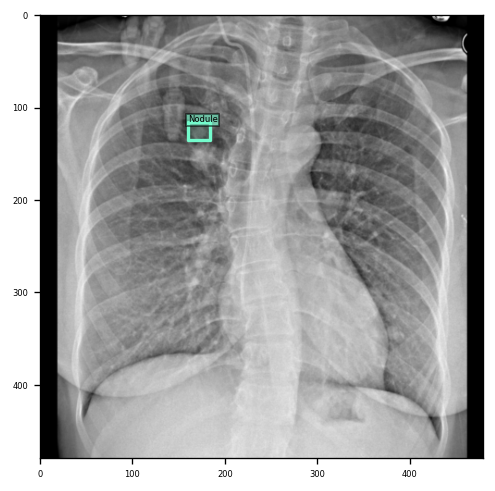

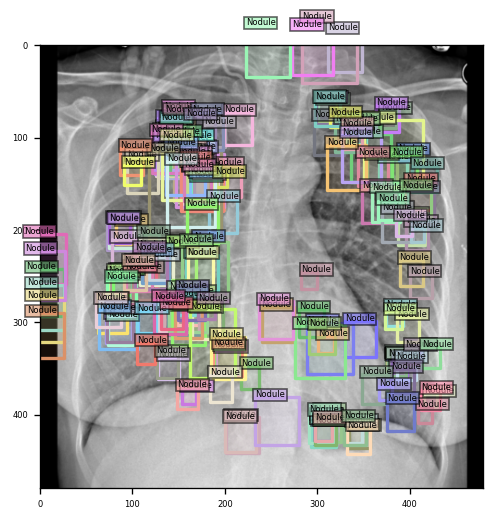

GroundTruth: {'boxes': tensor([[0.3584, 0.2617, 0.0508, 0.0410]]), 'labels': tensor([1]), 'image_id': tensor([750]), 'area': tensor([479.8828]), 'iscrowd': tensor([0]), 'orig_size': tensor([1024, 1024]), 'size': tensor([480, 480])}

Predicted: {'boxes': tensor([[0.3654, 0.3200, 0.0808, 0.0895],
        [0.3579, 0.2661, 0.0636, 0.0680],
        [0.3522, 0.2968, 0.0953, 0.1143],
        [0.8042, 0.7222, 0.0468, 0.0525],
        [0.3588, 0.2698, 0.0576, 0.0701],
        [0.3012, 0.2577, 0.0570, 0.0678],
        [0.3000, 0.2553, 0.0568, 0.0703],
        [0.3656, 0.3177, 0.0737, 0.0856],
        [0.3590, 0.3003, 0.0827, 0.1057],
        [0.8039, 0.7240, 0.0428, 0.0436],
        [0.8050, 0.7242, 0.0409, 0.0424],
        [0.3004, 0.2619, 0.0487, 0.0571],
        [0.3033, 0.2081, 0.0465, 0.0507],
        [0.3661, 0.3163, 0.0652, 0.0762],
        [0.8043, 0.7227, 0.0404, 0.0451],
        [0.3037, 0.2010, 0.0550, 0.0677],
        [0.2985, 0.2296, 0.0661, 0.0847],
        [0.3012, 0.2043, 0.0606,

In [43]:
# Ground Truth
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

# Predicted
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

print("GroundTruth:", targets)
print()
print("Predicted:", pred_dict)
# print(pred_dict['boxes']*1024)
print()

print("mIoU:", calculate_miou(targets['boxes'], pred_dict['boxes'].cpu()) )

In [18]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (tuple): Coordinates of the first bounding box (x, y, width, height).
        box2 (tuple): Coordinates of the second bounding box (x, y, width, height).

    Returns:
        float: IoU score.
    """
    # Extract coordinates from the input tuples
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the coordinates of the intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    x_end_intersection = min(x1 + w1, x2 + w2)
    y_end_intersection = min(y1 + h1, y2 + h2)

    # Calculate the area of intersection
    intersection_area = max(0, x_end_intersection - x_intersection) * max(0, y_end_intersection - y_intersection)

    # Calculate the areas of both bounding boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate the union area (area1 + area2 - intersection_area)
    union_area = area1 + area2 - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area

    return iou

box1 = [0.8477, 0.6968, 0.1348, 0.0928]
box2 = [0.8793, 0.6991, 0.0698, 0.0746] # [0.8862, 0.6993, 0.0563, 0.0703] # [0.8930, 0.7017, 0.0455, 0.0740]
res_iou = calculate_iou(box1, box2)
print(res_iou)

0.4162520464545173


In [14]:
## NAD -- Custom Model Code

print("Image Size:",image[None].shape)
out_features, out_classifierHead, out_SegmentationHead = model.backbone.cuda()(image[None].cuda())
print()

print("Feature outputs from the Backbone:")
print( "Total Backbone features:", len(out_features) )
print(out_features[0].shape)
print(out_features[1].shape)
print(out_features[2].shape)
print(out_features[3].shape)
print()

print("Classification output from the Backbone:")
print(out_classifierHead.shape)
print()

print("Segmentation output from UperNet:")
print(out_SegmentationHead.shape)
print()

Image Size: torch.Size([1, 3, 800, 1201])

Feature outputs from the Backbone:
Total Backbone features: 4
torch.Size([1, 128, 200, 301])
torch.Size([1, 128, 100, 151])
torch.Size([1, 128, 50, 76])
torch.Size([1, 128, 25, 38])

Classification output from the Backbone:
torch.Size([1, 1000])

Segmentation output from UperNet:
torch.Size([1, 1, 800, 1201])



/home/nuislam/projects/DINO_Detection/models/dino/backbone.py:261: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_x = torch.tensor(out[-1])
/home/nuislam/.conda/envs/tf-tnt-gpu/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


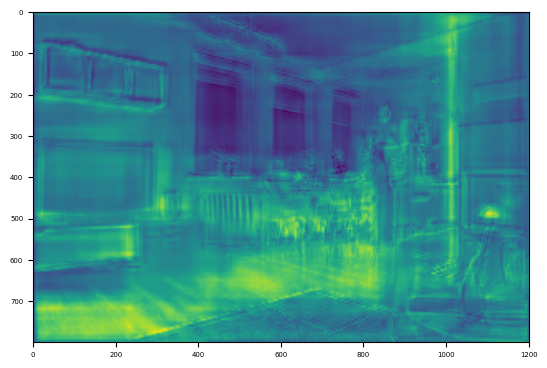

In [15]:
from matplotlib import pyplot as plt

plt.imshow( out_SegmentationHead[0,0].cpu().detach().numpy() )
plt.show()

In [15]:
fff = model.backbone.extra_features( image[None] )

AttributeError: 'Joiner' object has no attribute 'extra_features'

# 2. Visualize Custom Images

In [5]:
from PIL import Image
import datasets.transforms as T

In [6]:
image = Image.open("./figs/idea.jpg").convert("RGB") # load image

In [7]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [ ]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

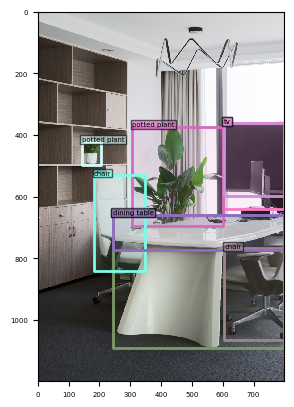

In [9]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

## Loading Jiaxuan's Swin-B + UperNet

torch.Size([1, 3, 800, 1201])
torch.Size([1, 3, 448, 448])
[Inside Extra Features]  torch.Size([1, 256, 56, 56])
[Inside Extra Features]  torch.Size([1, 512, 28, 28])
[Inside Extra Features]  torch.Size([1, 1024, 14, 14])
[Inside Extra Features]  torch.Size([1, 1024, 14, 14])

Segmentation Output: torch.Size([1, 1, 448, 448])


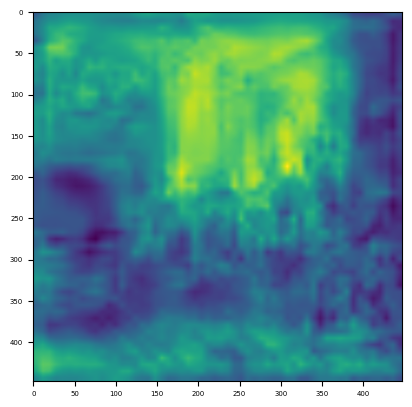

In [14]:
from torchvision import transforms
from swin_transformer_UperNet import UperNet_swin
from matplotlib import pyplot as plt

def save_image(input,idx):
    from PIL import Image

    def disparity_normalization(disp):  # disp is an array in uint8 data type
        _min = np.amin(disp)
        _max = np.amax(disp)
        disp_norm = (disp - _min) * 255.0 / (_max - _min)
        return np.uint8(disp_norm)

    im = disparity_normalization(input)
    im = Image.fromarray(im)
    im.save("{}.jpeg".format(idx))
    
    
target_size = (448, 448)
transform = transforms.Resize(target_size)

SU_input = image[None]
print(SU_input.shape)
SU_resized_image = transform(image)
print(SU_resized_image[None].shape)


model_SU = UperNet_swin(img_size=(448,448), num_classes=1)
model_SU.eval()

SU_output = model_SU( SU_resized_image[None] )

print()
print("Segmentation Output:", SU_output.shape)

plt.imshow( SU_output[0,0].cpu().detach().numpy() )
plt.show()

# save_image(SU_resized_image,0)

In [1]:
# Only EVAL
!~/.conda/envs/tf-tnt-gpu/bin/python -m torch.distributed.launch --nproc_per_node=1 main.py \
  --output_dir /data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/logs/DINO/SwinL_in22k_DINO_COCO_Val/  \
	-c config/DINO/DINO_4scale_swin.py --coco_path /scratch/jliang12/data/coco-2017/  \
	--eval --resume /data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/checkpoint0029_4scale_swin.pth \
	--options dn_scalar=100 embed_init_tgt=TRUE \
	dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
	dn_box_noise_scale=1.0 
#backbone_dir=/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/

/home/nuislam/.conda/envs/tf-tnt-gpu/lib/python3.7/site-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  FutureWarning,
  File "main.py", line 97
    def train_eval_detection_model(model, criterion, data_loader_train, optimizer, device, epoch, args.clip_max_norm, wo_class_error=wo_class_error, lr_scheduler=lr_scheduler, args=args, logger=(logger if args.save_log else None), ema_m=ema_m):
                                                                                                      ^
SyntaxError: invalid syntax
^C
Traceback (most recent call last):
  File "/home/nuislam/.conda/envs/tf-tnt-gpu/lib/python3.7/runp

In [4]:
# Training


# !coco_path="/scratch/jliang12/data/coco-2017/"
# !CONFIGFILE=config/DINO/DINO_4scale_swin.py
# ## checkpoint is for the DINO part's pretrained weights (obj365).
# !checkpoint="/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/checkpoint0029_4scale_swin.pth"
# !LOGFILE=/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/logs/Swin-L_DINO_FineTune_DEBUG
# ## BackboneDir - SwinL will find it's own pretrained weights (IN-22k-14M).
# !backbone_dir=/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection

# !export MASTER_ADDR=127.0.0.1
# !export MASTER_PORT=29502

# !~/.conda/envs/tf-tnt-gpu/bin/python main.py \
#     --output_dir /data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/logs/Swin-L_DINO_FineTune_DEBUG \
#     -c config/DINO/DINO_4scale_swin.py --pretrain_model_path /data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/checkpoint0029_4scale_swin.pth \
#     --coco_path /scratch/jliang12/data/coco-2017/ \
#     --options dn_scalar=100 embed_init_tgt=TRUE \
#     dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
#     dn_box_noise_scale=1.0 backbone_dir=/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection

!~/.conda/envs/tf-tnt-gpu/bin/python main.py --taskcomponent segmentation \
    --output_dir /data/jliang12/nuislam/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-L_IN22k_UperNet_FineTune_jsrtLung_DEBUG/ \
    -c config/DINO/DINO_4scale_swinLARGE.py \
    --coco_path /scratch/jliang12/data/coco-2017/ \
    --options dn_scalar=100 embed_init_tgt=TRUE \
    dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
    dn_box_noise_scale=1.0 backbone_dir=/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection

world size: 1, world rank: 0, local rank: 0, device_count: 1
world_size:1 rank:0 local_rank:0
| distributed init (rank 0): env://
Before torch.distributed.barrier()
End torch.distributed.barrier()
Loading config file from config/DINO/DINO_4scale_swinLARGE.py
[08/16 13:59:26.252]: git:
  sha: 69f0d5e3c8d8cbb6c0f4ed7bc1f518a8bfb8f8b2, status: has uncommited changes, branch: main

[08/16 13:59:26.252]: Command: main.py --taskcomponent segmentation --output_dir /data/jliang12/nuislam/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-L_IN22k_UperNet_FineTune_jsrtLung_DEBUG/ -c config/DINO/DINO_4scale_swinLARGE.py --coco_path /scratch/jliang12/data/coco-2017/ --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0 backbone_dir=/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection
[08/16 13:59:26.313]: Full config saved to /data/jliang12/nuislam/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-L_IN22k_UperNet_FineTune_jsrtLung

In [41]:
import torch
import torch.distributed as dist
import os 

os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29507'

if os.environ.get("ENABLE_DISTRIBUTED", "0") == "1":
    torch.distributed.init_process_group(backend='nccl', init_method='env://', world_size=1, rank=0)
    
model.cuda()
model_ddp = torch.nn.parallel.DistributedDataParallel(model, device_ids=[0], find_unused_parameters=True)

In [36]:
print(model_ddp)

DistributedDataParallel(
  (module): DINO(
    (transformer): DeformableTransformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): DeformableTransformerEncoderLayer(
            (self_attn): MSDeformAttn(
              (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
              (attention_weights): Linear(in_features=256, out_features=128, bias=True)
              (value_proj): Linear(in_features=256, out_features=256, bias=True)
              (output_proj): Linear(in_features=256, out_features=256, bias=True)
            )
            (dropout1): Dropout(p=0.0, inplace=False)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout2): Dropout(p=0.0, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (dropout3): Dropout(p=0.0, inplace=False)
            (nor

In [4]:
# print( model_ddp.module.backbone )

backboneSwin = model.backbone[0]
backboneSwin_W = backboneSwin.state_dict()

# for name, layer in backboneSwin.named_parameters():
#     print(name)
    
# for k,v in backboneSwin_W.items():
#     print(k)

In [16]:
w = torch.load("/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/swin_base_patch4_window7_224.pth")
# for k,v in w['model'].items():
#     print(k)

patch_embed.proj.weight
patch_embed.proj.bias
patch_embed.norm.weight
patch_embed.norm.bias
layers.0.blocks.0.norm1.weight
layers.0.blocks.0.norm1.bias
layers.0.blocks.0.attn.qkv.weight
layers.0.blocks.0.attn.qkv.bias
layers.0.blocks.0.attn.proj.weight
layers.0.blocks.0.attn.proj.bias
layers.0.blocks.0.norm2.weight
layers.0.blocks.0.norm2.bias
layers.0.blocks.0.mlp.fc1.weight
layers.0.blocks.0.mlp.fc1.bias
layers.0.blocks.0.mlp.fc2.weight
layers.0.blocks.0.mlp.fc2.bias
layers.0.blocks.1.norm1.weight
layers.0.blocks.1.norm1.bias
layers.0.blocks.1.attn.qkv.weight
layers.0.blocks.1.attn.qkv.bias
layers.0.blocks.1.attn.proj.weight
layers.0.blocks.1.attn.proj.bias
layers.0.blocks.1.norm2.weight
layers.0.blocks.1.norm2.bias
layers.0.blocks.1.mlp.fc1.weight
layers.0.blocks.1.mlp.fc1.bias
layers.0.blocks.1.mlp.fc2.weight
layers.0.blocks.1.mlp.fc2.bias
layers.0.downsample.norm.weight
layers.0.downsample.norm.bias
layers.1.blocks.0.norm1.weight
layers.1.blocks.0.norm1.bias
layers.1.blocks.0.attn

In [4]:
checkpoint = torch.load("/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/swin_base_patch4_window7_224_22k.pth", map_location='cpu')
state_dict = {k.replace("module.", ""): v for k, v in checkpoint['model'].items()}

result = model.backbone[0].load_state_dict(state_dict, strict=False)
# result = model.load_state_dict(state_dict, strict=False)
# print(result)
print( sum(model.backbone.classification_norm.weight) )
print()

# Define the renaming dictionary
renaming_dict = {
    'norm.weight': 'backbone.classification_norm.weight',
    'norm.bias': 'backbone.classification_norm.bias',
    # 'head.weight': 'backbone.classification_head.weight',
    # 'head.bias': 'backbone.classification_head.bias'
}
# Create a new state dictionary with the renamed keys
new_state_dict = {}
for old_key, new_key in renaming_dict.items():
    new_state_dict[new_key] = state_dict[old_key]
result = model.load_state_dict(new_state_dict, strict=False)
# print(result)

print( sum(model.backbone.classification_norm.weight) )

# model.backbone.classification_head.weight = .load_state_dictstate_dict['head.weight']

# print( state_dict['head.weight'] )

# backbone.classification_head.weight
# backbone.classification_head.bias
# 'backbone.classification_norm.weight'
# 'backbone.classification_norm.bias'

# norm.weight
# norm.bias
# head.weight
# head.bias

tensor(1024., grad_fn=<AddBackward0>)

tensor(2047.7009, grad_fn=<AddBackward0>)


In [45]:
from swin_transformer_UperNet import UperNet_swin
from swin_transformer_modified import SwinTransformer

# SwinB_Model_Original = UperNet_swin(img_size = 448, hidden_size = 128, num_classes = 1, window_size = 7, depth=[ 2, 2, 18, 2 ], heads=[ 4, 8, 16, 32 ])
# SwinB_Model_Original = UperNet_swin(img_size=448, num_classes=1)

SwinB_Model_Original = SwinTransformer(img_size=224, patch_size=4, in_chans=3, num_classes=0, embed_dim=128, depths=[ 2, 2, 18, 2 ],
                                          num_heads= [ 4, 8, 16, 32 ], window_size=7, mlp_ratio=4.,
                                          qkv_bias=True, qk_scale=None, drop_rate=0, drop_path_rate=0.1, ape=False, patch_norm=True, use_checkpoint=False)

# SwinB_Model_Original_state = SwinB_Model_Original.state_dict()
# for k,v in SwinB_Model_Original_state.items():
#     print(k)


checkpoint = torch.load("/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/swin_base_patch4_window7_224_22k.pth", map_location='cpu')
# checkpoint = torch.load("/data/jliang12/nuislam/Model_Checkpoints/DINO_Detection/swin_large_patch4_window7_224_22k.pth", map_location='cpu')
state_dict = {k.replace("module.", ""): v for k, v in checkpoint['model'].items()}

result = SwinB_Model_Original.load_state_dict(state_dict, strict=True)

RuntimeError: Error(s) in loading state_dict for SwinTransformer:
	Unexpected key(s) in state_dict: "head.weight", "head.bias". 

In [44]:
model_weights = torch.load("/home/nuislam/projects/TNT_modified_RSNAexams/Pretrained_weights/swin_base_patch4_window7_224_IN1k.pth")
result = SwinB_Model_Original.load_state_dict(state_dict, strict=True)

# for k,v in model_weights['model'].items():
#     print(k)

RuntimeError: Error(s) in loading state_dict for SwinTransformer:
	Missing key(s) in state_dict: "layers.3.blocks.1.attn_mask". 
	Unexpected key(s) in state_dict: "head.weight", "head.bias". 
	size mismatch for layers.0.blocks.1.attn_mask: copying a param with shape torch.Size([64, 49, 49]) from checkpoint, the shape in current model is torch.Size([256, 49, 49]).
	size mismatch for layers.1.blocks.1.attn_mask: copying a param with shape torch.Size([16, 49, 49]) from checkpoint, the shape in current model is torch.Size([64, 49, 49]).
	size mismatch for layers.2.blocks.1.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.3.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.5.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.7.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.9.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.11.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.13.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.15.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).
	size mismatch for layers.2.blocks.17.attn_mask: copying a param with shape torch.Size([4, 49, 49]) from checkpoint, the shape in current model is torch.Size([16, 49, 49]).

In [8]:
import timm
timm_swinB = timm.create_model('swin_base_patch4_window7_224_in22k', num_classes=1000, pretrained=True)

print("timm Swin-B Params:\n"+json.dumps({n: p.numel() for n, p in timm_swinB.named_parameters() if p.requires_grad}, indent=2))

timm Swin-B Params:
{
  "patch_embed.proj.weight": 6144,
  "patch_embed.proj.bias": 128,
  "patch_embed.norm.weight": 128,
  "patch_embed.norm.bias": 128,
  "layers.0.blocks.0.norm1.weight": 128,
  "layers.0.blocks.0.norm1.bias": 128,
  "layers.0.blocks.0.attn.relative_position_bias_table": 676,
  "layers.0.blocks.0.attn.qkv.weight": 49152,
  "layers.0.blocks.0.attn.qkv.bias": 384,
  "layers.0.blocks.0.attn.proj.weight": 16384,
  "layers.0.blocks.0.attn.proj.bias": 128,
  "layers.0.blocks.0.norm2.weight": 128,
  "layers.0.blocks.0.norm2.bias": 128,
  "layers.0.blocks.0.mlp.fc1.weight": 65536,
  "layers.0.blocks.0.mlp.fc1.bias": 512,
  "layers.0.blocks.0.mlp.fc2.weight": 65536,
  "layers.0.blocks.0.mlp.fc2.bias": 128,
  "layers.0.blocks.1.norm1.weight": 128,
  "layers.0.blocks.1.norm1.bias": 128,
  "layers.0.blocks.1.attn.relative_position_bias_table": 676,
  "layers.0.blocks.1.attn.qkv.weight": 49152,
  "layers.0.blocks.1.attn.qkv.bias": 384,
  "layers.0.blocks.1.attn.proj.weight": 163

In [4]:
# from swin_transformer_orgModified import build_swin_transformer
# SwinB_model_org = build_swin_transformer('swin_B_224_22k', pretrain_img_size=224, dilation=False)

from swin_transformer_changed import build_swin_transformer
SwinB_model_org = build_swin_transformer('swin_B_224_22k', pretrain_img_size=224, dilation=False)


# print( model )

# ww = model.state_dict()
# for k,v in ww.items():
#     print(k, v.shape)

NameError: name 'H' is not defined

In [5]:
print(SwinB_model_org.num_features)

x = torch.rand(2, 3, 224, 224)
outputs = SwinB_model_org(x)
print(outputs[0].shape)
print(outputs[1].shape)
print(outputs[2].shape)
print(outputs[3].shape)

1024
[Inside Forward_Features Function] out torch.Size([2, 256, 28, 28])


RuntimeError: Given normalized_shape=[256], expected input with shape [*, 256], but got input of size[2, 196, 512]

## Visualizing LR

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 1
    lr: 1e-06
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0
) <timm.scheduler.cosine_lr.CosineLRScheduler object at 0x155430ff7310>

0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 0.9999316524962345
11 0.999726628670463
12 0.9993849845741524
13 0.9989068136093873
14 0.9982922465033349
15 0.9975414512725057
16 0.9966546331768191
17 0.9956320346634876
18 0.9944739353007342
19 0.9931806517013612
20 0.9917525374361912
21 0.9901899829374047
22 0.9884934153917997
23 0.9866632986240029
24 0.9847001329696652
25 0.9826044551386743
26 0.9803768380684241
27 0.9780178907671788
28 0.9755282581475768
29 0.9729086208503173
30 0.9701596950580806
31 0.9672822322997304
32 0.9642770192448535
33 0.9611448774886924
34 0.9578866633275287
35 0.9545032675245813
36 0.9509956150664796
37 0.9473646649103817
38 0.9436114097218059
39 0.9397368756032445
40 0.9357421218136386
41 0.931628240478787
42 0.9273963562927695
43 0.923047

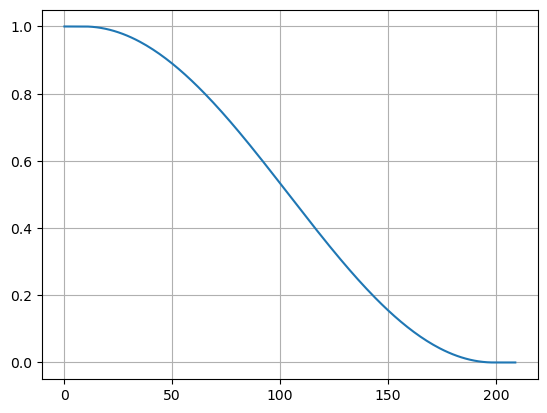

In [6]:
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs, create_optimizer
import torch
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from matplotlib import pyplot as plt
import numpy as np

def step_decay_cosine(step, learning_rate, num_epochs, warmup_epochs=5):
    lr = learning_rate
    progress = (step - warmup_epochs) / float(num_epochs - warmup_epochs)
    progress = np.clip(progress, 0.0, 1.0)
    #decay_type == 'cosine':
    lr = lr * 0.5 * (1. + np.cos(np.pi * progress))
    if warmup_epochs:
      # lr = lr * np.minimum(1., step / warmup_epochs)
      lr = lr
    return lr

class arg:
    opt = 'sgd'
    lr = 1
    weight_decay = 0.0
    momentum = 0.9
    epochs = 200
    sched = 'cosine'
    min_lr = 1e-5
    warmup_lr = 1e-6
    warmup_epochs = 20
    cooldown_epochs = 10
    
model = torch.nn.Conv2d(1,1,1)
optimizer = create_optimizer_v2(model, **optimizer_kwargs(cfg=arg))
lr_scheduler, num_epochs = create_scheduler(arg,optimizer)
print(optimizer, lr_scheduler)

print()
lr_list = []
for i in range(num_epochs):
    # print(optimizer.state_dict()['param_groups'][0]['lr'])
    lr_ = step_decay_cosine(i+1, arg.lr, arg.epochs, warmup_epochs=10)
    print(i, lr_)
    lr_list.append(lr_)
    
    # lr_scheduler.step(i+1, 0)
    # lr_list.append((optimizer.state_dict()['param_groups'][0]['lr']))
                   
plt.grid()
plt.plot(range(len(lr_list)), lr_list)          
        